<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI MRS Calibration Notebook  #2 (Multiband and Parallel Processing Demo; Point Sources) #

**Author**: David Law, AURA Associate Astronomer, MIRI branch
<br>
**Last Updated**: June 18, 2021
<br>
**Pipeline Version**: 1.1.0

## Table of contents
1. [Introduction](#intro)<br>
   1.1 [Purpose of this Notebook](#purpose)<br>
   1.2 [Input Simulations](#inputs)<br>
   1.3 [Caveats for Simulated Data](#mirisim)<br>
2. [Setup](#setup)<br>
   2.1 [CRDS Context](#crds)<br>
   2.2 [Python Imports](#imports)<br>
   2.3 [Data I/O Directories](#iodir)<br>
   2.4 [Reprocessing Flag](#redo)<br>
   2.5 [Multithreading Function](#mthread)<br>
3. [Detector1 Pipeline](#det1)<br>
4. [Spec2 Pipeline](#spec2)<br>
5. [Spec3 Pipeline: Default configuration (12 per-band cubes)](#spec3)<br>
6. [Spec3 Pipeline: Channel configuration (4 per-channel cubes)](#spec3_v2)<br>
7. [Spec3 Pipeline: Uber configuration (1 all-wavelength cube)](#spec3_v3)<br>
8. [Examine the output cubes, and compare spectra to the simulation inputs](#examine)<br>

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

### 1.1<font color='white'>-</font>Purpose of this Notebook<a class="anchor" id="purpose"></a> ###

In this notebook we provide a series of realistic example for running the JWST pipeline on large quantities of MIRI MRS data similar to those that will be obtained by many Cycle 1 observing programs.  In particular, we focus on handling issues related to multi-band ditheredobservations spanning the MRS wavelength range, both as regards efficient reduction times and data display issues.  We therefore do not discuss the purpose and input/output of each individual pipeline step, but focus on ways to modify the final pipeline output for the best scientific utility.  For a walkthrough of individual steps, see Notebook #1.  Similarly, this will cover the baseline pipeline as it exists in May 2021 and does not touch advanced algorithms or steps still under development.

This notebook is specifically for POINT-SOURCE observations; extended source observations are somewhat different and will be presented in MRS Notebook #3.

We will start with a simple simulated MRS observation (created using mirisim: https://wiki.miricle.org/Public/MIRISim_Public) with a dedicated background, process the data through the Detector1 pipeline (which turns raw detector counts into uncalibrated rate images), the Spec2 pipeline (which turns uncalibrated rate images into calibrated rate images), and the Spec3 pipeline (which turns calibrated rate images into composite data cubes and extracted 1d spectra).

A few additional caveats:
- This notebook covers the v1.1.0 baseline pipeline as it existed in February 2021. The pipeline is under continuous development and there are therefore some changes in the latest pipeline build that will not be reflected here.
- Likewise, there are some advanced algorithms slated for development prior to cycle 1 observations that will not be discussed here.

### 1.2<font color='white'>-</font>Input Simulations<a class="anchor" id="inputs"></a> ###

As input to this notebook, we'll be using a 4-pt dithered observation of a point source created using mirisim that covers the entire MRS waveband from 5-28 micron (i.e., both MIRI detectors, with the SHORT/MEDIUM/LONG grating configurations).  The point source spectrum is chosen to be astrophysically realistic, in this case taken from the galaxy NGC 5728.

<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/scene2.png' alt="nb1input" width="900px"/> 

### 1.3<font color='white'>-</font>Caveats for Simulated Data<a class="anchor" id="mirisim"></a> ###

As noted above, in this notebook we will be processing simulated data created with the 'mirisim' tool.  Like the pipeline, mirisim is also an evolving piece of software and there are multiple known issues that can cause problems.  A few of the most important such mirisim issues include:

- FAST mode has incorrect noise properties, rendering FAST mode data processed by the pipeline unreliable.  The simulations in this notebook therefore use simulated SLOW mode data.

- Extended sources are not simulated unless they meet a minimum size that varies with each band.

- Point sources are not simulated properly, with the PSF profile being simulated incorrectly in the cores.  Mirisim simulations therefore should not be used to study the PSF shape.

- Reference pixels are not treated consistently, the refpix step of detector1 must therefore be turned off to process mirisim data without artifacts.

- Channel 4 flux calibration is incorrect in mirisim.  No workaround is currently available- channel 4 fluxes provided by the pipeline from simulated data will be incorrect.

- WCS alignment is incorrect in mirisim, causing sources to jump in location by a couple of pixels between channels.  No workaround is available- do not use mirisim data to test spatial alignment.

- Flux conservation is not perfect within mirisim.  Likewise, the aperture correction factors in use by the pipeline correspond to the expected performance in flight (to be updated during on-orbit commissioning) and are not well matched to mirisim data.  No workaround available, do not use mirisim data to test flux conservation.

- mirisim does not add all of the necessary header keywords for the pipeline to know how to do background subtraction, identify source type, etc.  In order to get these APT-derived keywords correct they will need to be set manually.

<hr style="border:1px solid gray"> </hr>

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we set things up a number of necessary things in order for the pipeline to run successfully.

First we'll set the CRDS context; this dictates the versions of various pipeline reference files to use.  Ordinarily you wouldn't want to set a specific version as the latest pipeline should already use the most-recent reference files (and hard-coding a version could get you old reference files that have since been replaced).  However, since this demo is using an old version 1.1.0 of the pipeline, we need to tell it to get some more recent reference files.

Next we'll import the various python packages that we're actually going to use in this notebook, including both generic utility functions and the actual pipeline modules themselves.  This includes a variety of multiprocessing functions that allow us to parallelize pipeline reductions of many exposures using the multiple cores now standard in many computers.

Next, we'll specify the data directory structure that we want to use.  In order to keep our filesystem clean we'll separate simulated inputs and outputs from each pipeline stage into their own folders.

Finally, for convenience in this JWebbinar we'll define a flag that sets whether or not to actually run some of the longer pipeline steps in this notebook or just to rely upon cached reductions provided ahead of time.  This is because a number of steps (particularly building 3d data cubes) can take quite a long time to run, and in a short Webbinar we don't want to be waiting for them to all run in real time.  This flag is set to False by default for use in the live Webbinar; if you want to experiment with running all steps yourself ahead of time just set this flag to True.  Total notebook runtime with True/False values is about 6 hours (8 CPUs; roughly 20 hours with just 1 CPU) vs 10 seconds.

### 2.1<font color='white'>-</font>CRDS Context<a class="anchor" id="crds"></a> ###

Set our CRDS context for reference files (see https://jwst-crds.stsci.edu/)
We need to do this because version 1.1.0 of the pipeline does not pull in some recent reference file updates by default.

In [1]:
# Comment out this line if you want to use the latest reference files tagged for a specific pipeline version
%env CRDS_CONTEXT jwst_0723.pmap

env: CRDS_CONTEXT=jwst_0723.pmap


### 2.2<font color='white'>-</font>Python Imports <a class="anchor" id="imports"></a> ###

In [2]:
# Import packages for multiprocessing.  These won't be used on the online demo, but can be
# very useful for local data processing unless/until they get integrated natively into
# the cube building code.  These need to be imported before anything else.

import multiprocessing
multiprocessing.set_start_method('fork')
from multiprocessing import Pool
import os

# Set the maximum number of processes to spawn based on available cores
usage='none' # Either 'none' (single thread), 'quarter', 'half', or 'all' available cores

In [3]:
# Multiprocessing can snarl up the Jupyter notebook display, so if we're doing it we need to
# tell the pipeline to send its output to a log file instead of the screen BEFORE we import
# the pipeline.

# If not multiprocessing, remove the local .cfg file that the pipeline will look for
if (usage == 'none'):
    if os.path.exists('stpipe-log.cfg'):
        os.remove('stpipe-log.cfg')

# If multiprocessing, create the .cfg file that the pipeline will look for
else:
    # Create a .cfg file in the working directory to specify where to send pipeline output to
    print('[*]',file=open('stpipe-log.cfg',"w"))
    print('handler = file:pipeline.log',file=open('stpipe-log.cfg',"a"))
    print('level = INFO',file=open('stpipe-log.cfg',"a"))

In [4]:
num_cores = multiprocessing.cpu_count()
if usage == 'quarter':
    maxp = num_cores // 4 or 1
elif usage == 'half':
    maxp = num_cores // 2 or 1
elif usage == 'all':
    maxp = num_cores
else:
    maxp = 1

print('We will use '+str(maxp)+' CPUs in this run')

We will use 1 CPUs in this run


In [5]:
# Now let's use the entire available screen width for the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [6]:
# Basic system utilities for interacting with files
import glob, sys, os, time, shutil, warnings

# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
from astropy.io import ascii
# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)

# Numpy for doing calculations
import numpy as np

# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

In [7]:
# Import the base JWST package and warn if not the expected version
import jwst

if jwst.__version__ != '1.1.0':
    warnings.warn(f"You are running version {jwst.__version__} of the jwst "
                  "module instead of the intended 1.1.0.")

In [8]:
# JWST pipelines (encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# JWST pipeline utilities
from jwst import datamodels # JWST datamodels
import jwst.ramp_fitting.utils as utils # Utilities for handling multiprocessing
from jwst.associations import asn_from_list as afl # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file

# If using pipeline version 1.2.0 or later, the dqflags function is contained in the 'stcal' product
#from stcal import dqflags # Utilities for working with the data quality (DQ) arrays
# Since this demo uses version 1.1.0 of the JWST pipeline, we need to instead import dqflags from 
from jwst.datamodels import dqflags

# If using pipeline version 1.2.0 or later, some multiprocessing functions (mostly used in ramp fitting)
# are contained in the 'stcal' product:
#import stcal.ramp_fitting.utils as utils # Utilities for handling multiprocessing
# Since this demo uses version 1.1.0 of the JWST pipeline, we need to instead import from jwst:
import jwst.ramp_fitting.utils as utils # Utilities for handling multiprocessing

2021-06-18 13:03:50,080 - stpipe - WARNING - /Users/dlaw/anaconda3/envs/jwst1.1.0/lib/python3.9/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '



In [9]:
# Print out what pipeline version we're using
print('JWST pipeline version', jwst.__version__)

JWST pipeline version 1.1.0


### 2.3<font color='white'>-</font>Data I/O Directories <a class="anchor" id="iodir"></a> ###

Data can be obtained from https://stsci.box.com/s/kdzsylowpp5q6herx4hc23noc9z71z0f <BR>
Since the contents of this Box directory are quite large (roughly 9 GB, including multiple inputs, outputs, and intermediate products), downloading the data for home use is left to the user in whichever means they determine to be best.
    
By default, the contents of this Box directory are assumed to be in the same directory as this notebook.  However, it is also possible to install them in another location and use this as a cache of pre-reduced results against which new reductions can be compared.

In [10]:
# If running on your own machine, cache_dir should point to where you installed the data from Box
cache_dir = './'

# If running remotely in the online JWebbinar session, the cache directed is located here:
#cache_dir = '/home/shared/preloaded-fits/mrs-data/notebook2/'

In [11]:
# Specify some working directories to use so that everything is more organized.<br>
mirisim_dir = 'stage0/' # Simulated inputs are here
det1_dir = 'stage1/' # Detector1 pipeline outputs will go here
spec2_dir = 'stage2/' # Spec2 pipeline outputs will go here
spec3_dir = 'stage3/' # Spec3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)

### 2.4<font color='white'>-</font>Reprocessing Flag<a class="anchor" id="redo"></a> ###

Since some parts of the pipeline take a long time to run, for a first use of this notebook we will disable those steps and simply copy results out of the cache for informational purposes.  In order to run the full pipeline on the data, or to run this notebook on your own simulated data not downloaded from the Box link above, this reprocessing flag will need to be enabled.

In [12]:
# To rerun all steps use:
#redolong = True
# To skip lengthy steps and copy results from the cache use:
redolong = False

### 2.5<font color='white'>-</font>Multithreading Function<a class="anchor" id="mthread"></a> ###

In [13]:
# Define a function that can oversee the multiprocessing
# We'll just pass this a function name and a set of inputs, and it'll figure out the
# multithreading accordingly.
def runmany(step,filenames):
    if __name__ == '__main__':
        p = Pool(maxp)
        res = p.map(step, filenames)
        p.close()
        p.join()

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Detector1 Pipeline <a class="anchor" id="det1"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our simulated data through the Detector1 pipeline to create Lvl2a data products (i.e., uncalibrated slope images).  We will turn off the reference pixel subtraction step as it does not handle mirisim data well.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html
</div>

In [14]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

In [15]:
# First we'll define a function that will call the detector1 pipeline with our desired set of parameters
# We won't enumerate the individual steps
def rundet1(filenames):
    det1 = Detector1Pipeline() # Instantiate the pipeline
    det1.output_dir = det1_dir # Specify where the output should go
    det1.refpix.skip = True # Skip the reference pixel subtraction (as it doesn't interact well with simulated data)
    det1.save_results = True # Save the final resulting _rate.fits files
    det1(filenames) # Run the pipeline on an input list of files

In [16]:
# Now let's look for input files in our (cached) mirisim simulation directory
sstring = cache_dir + mirisim_dir + 'det*exp1.fits'
simfiles = sorted(glob.glob(sstring))
print('Found ' + str(len(simfiles)) + ' input files to process')

Found 24 input files to process


In [17]:
# Run the pipeline on these input files by a simple loop over our pipeline function

# If rerunning long pipeline steps, actually run the step
if (redolong == True):
    runmany(rundet1,simfiles)
    
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = cache_dir + det1_dir + 'det*rate.fits'
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file,cache_dir,'./')
        shutil.copy(file,outfile)

In [18]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 0.8857 seconds


4.<font color='white'>-</font>Spec2 Pipeline <a class="anchor" id="spec2"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our simulated data through the Spec2 pipeline in order to produce Lvl2b data products (i.e., calibrated slope images and quick-look data cubes and 1d spectra).  We will not look into each individual step in detail- see MRS Notebook #1 for a guide to that.

We will skip the 'background' step as this is largely a placeholder for in case pixel-by-pixel differencing of science and background pointings turns out to be necessary on orbit.

Likewise, we will skip the 'straylight' step as this is unnecessary for simulated data and can sometimes introduce artifacts at present.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html
</div>

In [19]:
# Define a function that will call the spec2 pipeline with our desired set of parameters
# We'll list the individual steps just to make it clear what's running
def runspec2(filename):
    spec2 = Spec2Pipeline()
    spec2.output_dir = spec2_dir
    
    spec2.assign_wcs.skip = False # Derives the world coordinate solution- never skip this!
    spec2.bkg_subtract.skip = True # Performs pixel-wise background subtraction- placeholder in case necessary
    spec2.flat_field.skip = False # Applies a pixel flatfield (currently all unity)
    spec2.srctype.skip = False # Guesses at the source type (point/extended) based on APT inputs and dither information
    spec2.straylight.skip = True # Model and subtraction straylight (may want to skip)
    spec2.fringe.skip = False # Applies static fringe flat to remove fringes from the data
    spec2.photom.skip = False # Applies photometric calibration flat
    spec2.cube_build.skip = False # Build quicklook data cubes (needed for Master background in stage 3)
    spec2.extract_1d.skip = False # Extract quicklook 1d spectra (needed for Master background in stage 3)
    
    spec2.save_results = True
    spec2(filename)

In [20]:
# Look for input uncalibrated slope files from the Detector1 pipeline
sstring = det1_dir + 'det*rate.fits'
ratefiles = sorted(glob.glob(sstring))
print('Found ' + str(len(ratefiles)) + ' input files to process')

Found 24 input files to process


In [21]:
# Simulated data doesn't have the right keywords to tell the pipeline what kind of data is being processed.
# Overwrite rate file header info to specify that these are point sources.
for ii in range(0, len(ratefiles)):
    hdu = fits.open(ratefiles[ii])
    hdu[1].header['SRCTYPE']='POINT'
    hdu.writeto(ratefiles[ii],overwrite=True)
    hdu.close()

In [22]:
# If rerunning long pipeline steps, actually run the step
if (redolong == True):
    runmany(runspec2,ratefiles)
    
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = cache_dir + spec2_dir + 'det*.fits'
    files=sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file,cache_dir,'./')
        shutil.copy(file,outfile)

In [23]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 6.8764 seconds


5.<font color='white'>-</font>Spec3 Pipeline: Default configuration (12 per-band cubes)<a class="anchor" id="spec3"></a>
------------------

<div class="alert alert-block alert-warning">
Here we'll run the Spec3 pipeline in close to 'default' configuration, where we produce a composite data cube from all dithered exposures for each of the 12 MRS bands.

    
Note that we will not be using the 'Master Background' step as we're working with point sources.  At the present time background subtraction for point sources is performed during final spectral extraction from the 3d data cubes using an annulus to define the background region.  If we were working with extended sources, we would also need to populate our Level3 Association file with the appropriate Spec2 X1d filenames of the dedicated background observations.

A word of caution: the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.  What that means is that if you intend to sum spectra within an aperture you need to be sure to multiply by the pixel area in steradians first in order to get a spectrum in flux units (the PIXAR_SR keyword can be found in the SCI extension header).  This correction is already build into the pipeline Extract1D algorithm.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html
    
</div>

In [24]:
# Define a useful function to write out a Lvl3 association file from an input list
def writel3asn(files,asnfile,prodname,**kwargs):
    # Define the basic association of science files
    asn = afl.asn_from_list(files,rule=DMS_Level3_Base,product_name=prodname)
    # Add any background files to the association
    if ('bg' in kwargs):
        for bgfile in kwargs['bg']:
            asn['products'][0]['members'].append({'expname': bgfile, 'exptype':'background'})
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [25]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 6.8876 seconds


In [26]:
# Define a convenience function that will split the input _cal.fits files into their corresponding bands
def sort_calfiles(files):
    nfiles = len(files)

    channel = []
    band = []

    for file in files:
        hdr = (fits.open(file))[0].header
        channel.append(hdr['CHANNEL'])
        band.append(hdr['BAND'])
    channel = np.array(channel)
    band = np.array(band)

    indx = np.where((channel == '12')&(band == 'SHORT'))
    files12A = files[indx]
    indx = np.where((channel == '12')&(band == 'MEDIUM'))
    files12B = files[indx]
    indx = np.where((channel == '12')&(band == 'LONG'))
    files12C = files[indx]
    indx = np.where((channel == '34')&(band == 'SHORT'))
    files34A = files[indx]
    indx = np.where((channel == '34')&(band == 'MEDIUM'))
    files34B = files[indx]
    indx = np.where((channel == '34')&(band == 'LONG'))
    files34C = files[indx]
    
    return files12A,files12B,files12C,files34A,files34B,files34C

In [27]:
# Find and sort all of the input files
sstring = spec2_dir + 'det*cal.fits'
calfiles = np.array(sorted(glob.glob(sstring)))
sortfiles = sort_calfiles(calfiles) # Split them up into bands
print('Found ' + str(len(calfiles)) + ' input files to process')

Found 24 input files to process


In [28]:
# Create association files for each band with exposures
# Write out the files and add the filenames into our list

# We could also write all files to a single .json file and cube_build would be smart enough
# to know how to split this up, but then we wouldn't be able to parallelize the runs.
asnlist = []
names=['12A','12B','12C','34A','34B','34C']
for ii in range(0,len(sortfiles)):
    thesefiles = sortfiles[ii]
    ninband = len(thesefiles)
    if (ninband > 0):
        filename = 'l3asn-' + names[ii] + '.json'
        asnlist.append(filename)
        writel3asn(thesefiles,filename,'Level3')

In [29]:
# Define a function that will call the spec3 pipeline with our desired set of parameters
def runspec3(filename):
    # This initial setup is just to make sure that we get the latest parameter reference files
    # pulled in for our files.  This is a temporary workaround to get around an issue with
    # how this pipeline calling method works.
    crds_config = Spec3Pipeline.get_config_from_reference('l3asn-12A.json')# The exact asn file used doesn't matter
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    
    spec3.output_dir = spec3_dir
    spec3.save_results = True
    
    spec3.master_background.skip = True # Computes and subtracts a master background signal
    spec3.outlier_detection.skip = False # Identifies and flags any pixels with values that produce outliers in overlapping regions of cube space
    spec3.mrs_imatch.skip = False # Ensure that there are no jumps in the background between individual exposures
    spec3.cube_build.skip = False # Build the composite data cubes
    spec3.extract_1d.skip = False # Extract 1d spectra from the composite data cubes

    spec3(filename)

In [30]:
# If rerunning long pipeline steps, actually run the step
if (redolong == True):
    runmany(runspec3,asnlist)
    
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = cache_dir + spec3_dir + 'Level3*.fits'
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file,cache_dir,'./')
        shutil.copy(file,outfile)

In [31]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 7.3442 seconds


6.<font color='white'>-</font>Spec3 Pipeline: Channel configuration (4 per-channel cubes)<a class="anchor" id="spec3_v2"></a>
------------------

<div class="alert alert-block alert-warning">
Previously we used the Spec3 pipeline to make a composite data cube for each of the 12 MRS bands, but the pipeline can also be configured to build cubes combining many bands together into the same data cube.  For instance, it can produce 4 per-channel data cubes instead (where, e.g., 1A, 1B, and 1C wavelengths are all combined into a single 'Ch1' cube).  Note that this doesn't rely on sampling the individual band cubes- the 2d calibrated data are simply built directly onto this new output grid.

Let's run Spec3 again, but this time making cubes that cover a full channel (composed of three individual bands).  Note that there's currently a bug in cube_build such that it can't automatically make cubes for all 4 channels at once; in the meantime we'll just do it for Channel 1.
</div>

In [32]:
# First we'll make an association file that includes all of the different band exposures
sstring = spec2_dir + 'det*cal.fits'
calfiles = np.array(sorted(glob.glob(sstring)))
writel3asn(calfiles,'l3asn.json','Level3')
print('Found ' + str(len(calfiles)) + ' input files to process')

Found 24 input files to process


In [33]:
# And we'll define a new Spec3 instance with different cube building parameters
# We list a few of these options here (for more extensive options see
# https://jwst-pipeline.readthedocs.io/en/latest/jwst/cube_build/arguments.html)
# We'll skip master_background, outlier detection, and mrs imatch this time to save runtime
def runspec3_ch(filename):
    # This initial setup is just to make sure that we get the latest parameter reference files
    # pulled in for our files.  This is a temporary workaround to get around an issue with
    # how this pipeline calling method works.
    crds_config = Spec3Pipeline.get_config_from_reference('l3asn.json')# The exact asn file used doesn't matter
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    
    spec3.output_dir = spec3_dir
    spec3.save_results = True
    
    # Whether to skip individual pipeline steps or not
    spec3.master_background.skip = True # Computes and subtracts a master background signal
    spec3.outlier_detection.skip = True # Identifies and flags any pixels with values that produce outliers in overlapping regions of cube space
    spec3.mrs_imatch.skip = True # Ensure that there are no jumps in the background between individual exposures
    spec3.cube_build.skip = False # Build the composite data cubes
    spec3.extract_1d.skip = False # Extract 1d spectra from the composite data cubes
    
    # Some of the available cube building options
    spec3.cube_build.output_file = 'chancube' # Custom output name
    #spec3.cube_build.output_type = 'channel' # Ordinarily this is how we'd specify per-channel output, but this isn't working in 1.1.0
    #spec3.cube_build.weighting = 'emsm' # Current default cube build method uses a radial exponential Modified
                                        # Shepard algorithm, but a 'driz' 3d Drizzle option is coming soon
    #spec3.cube_build.coord_system = 'ifualign' # The default is 'skyalign'; they differ in whether 
                                                # cube is aligned with North/East or the IFU field angle
    spec3.cube_build.channel = '1' # Build everything from channel 1 into a single cube
    #spec3.cube_build.scale1 = 0.5 # Output cube spaxel scale (arcsec) in dimension 1 if setting it by hand
    #spec3.cube_build.scale2 = 0.5 # Output cube spaxel scale (arcsec) in dimension 2 if setting it by hand
    #spec3.cube_build.scalew = 0.002 # Output cube spaxel size (microns) in dimension 3 if setting it by hand
    
    spec3(filename)

In [34]:
# If rerunning long pipeline steps, actually run the step
if (redolong == True):
    runspec3_ch('l3asn.json')
    
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = cache_dir + spec3_dir + 'chancube*.fits'
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file,cache_dir,'./')
        shutil.copy(file,outfile)

7.<font color='white'>-</font>Spec3 Pipeline: Uber configuration (1 all-wavelength cube)<a class="anchor" id="spec3_v3"></a>
------------------

<div class="alert alert-block alert-warning">
Now we can also tell the pipeline to combine **everything** into a single cube spanning the wavelength range from 5-28 microns.

These cubes are quite unwieldy; they're about 9000 spectral planes in length and nearly 1GB in size each.  However, it can be a convenience to have all of the bands together in one place.  There are significant drawbacks to these cubes as well though.  Since both the PSF and field size change substantially across the MIRI wavelength range the ideal cube spaxel sizes also change.  Since cubes can only use a spaxel size in the spatial dimension, a single cube combining both Channel 1 and Channel 4 must therefore either dramatically undersample the data at Ch1 or dramatically oversample the data at Ch4.  Likewise, the spectral sampling must change too, although we have more freedom here since the Cube Build algorithm defines a non-linear wavelength solution that changes step size with wavelength in order to more optimally sample spectral features at all wavelengths simultaneously.
</div>

In [35]:
# And we'll define a new Spec3 instance with different cube building parameters
# We list a few of these options here (for more extensive options see
# https://jwst-pipeline.readthedocs.io/en/latest/jwst/cube_build/arguments.html)
# We'll skip master_background, outlier detection, and mrs imatch this time to save runtime
def runspec3_all(filename):
    # This initial setup is just to make sure that we get the latest parameter reference files
    # pulled in for our files.  This is a temporary workaround to get around an issue with
    # how this pipeline calling method works.
    crds_config = Spec3Pipeline.get_config_from_reference('l3asn-12A.json')# The exact asn file used doesn't matter
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    
    spec3.output_dir = spec3_dir
    spec3.save_results = True
    
    # Whether to skip individual pipeline steps or not
    spec3.master_background.skip = True # Computes and subtracts a master background signal
    spec3.outlier_detection.skip = True # Identifies and flags any pixels with values that produce outliers in overlapping regions of cube space
    spec3.mrs_imatch.skip = True # Ensure that there are no jumps in the background between individual exposures
    spec3.cube_build.skip = False # Build the composite data cubes
    spec3.extract_1d.skip = False # Extract 1d spectra from the composite data cubes
    
    # Some of the available cube building options
    spec3.cube_build.output_file = 'allcube' # Custom output name
    spec3.cube_build.output_type = 'multi'
    #spec3.cube_build.weighting = 'emsm' # Current default cube build method uses a radial exponential Modified
                                        # Shepard algorithm, but a 'driz' 3d Drizzle option is coming soon
    #spec3.cube_build.coord_system = 'ifualign' # The default is 'skyalign'; they differ in whether 
                                                # cube is aligned with North/East or the IFU field angle
    #spec3.cube_build.channel = 'ALL' # Build everything from just channel 1 into a single cube
                                    # (we could also choose '2','3','4', or 'ALL')
    #spec3.cube_build.scale1 = 0.5 # Output cube spaxel scale (arcsec) in dimension 1 if setting it by hand
    #spec3.cube_build.scale2 = 0.5 # Output cube spaxel scale (arcsec) in dimension 2 if setting it by hand
    #spec3.cube_build.scalew = 0.002 # Output cube spaxel size (microns) in dimension 3 if setting it by hand
    
    spec3(filename)

In [36]:
# If rerunning long pipeline steps, actually run the step
if (redolong == True):
    runspec3_all('l3asn.json')
    
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = cache_dir + spec3_dir + 'allcube*.fits'
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file,cache_dir,'./')
        shutil.copy(file,outfile)

8.<font color='white'>-</font>Examine the output cubes, and compare spectra to the simulation inputs<a class="anchor" id="examine"></a>
------------------

<div class="alert alert-block alert-warning">
Now let's look at the final products (cubes and 1d spectra) created by the pipeline, and compare the different kinds of data cubes.

As above, remember that the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.
</div>

Text(0.5, 1.0, 'ALL Cube')

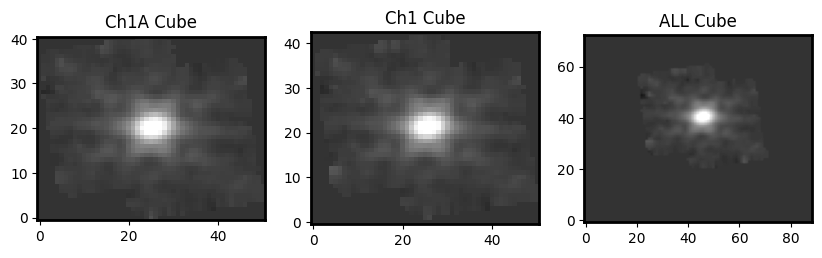

In [37]:
# Show an image of the Ch1A, Ch1, and ALL cubes
hdu1A = fits.open(spec3_dir + 'Level3_ch1-short_s3d.fits')
data1A = hdu1A['SCI'].data
hdr1A = hdu1A['SCI'].header
# Linear wavelength solution in per-band cubes
wave1A = np.arange(hdr1A['NAXIS3'])*hdr1A['CDELT3']+hdr1A['CRVAL3']

cubefile_ch1 = glob.glob(spec3_dir + 'chancube_ch1*s3d.fits')
hdu1 = fits.open(cubefile_ch1[0])
data1 = hdu1['SCI'].data
hdr1 = hdu1['SCI'].header
# Linear wavelength solution in per-channel cubes
wave1 = np.arange(hdr1['NAXIS3'])*hdr1['CDELT3']+hdr1['CRVAL3']

cubefile_all = glob.glob(spec3_dir + 'allcube_*s3d.fits')
hduALL = fits.open(cubefile_all[0])
dataALL = hduALL['SCI'].data
hdrALL = hduALL['SCI'].header
# Reference table of wavelengths for the ALL cube
waveALL = hduALL['WCS-TABLE'].data['wavelength'][0]

# Use a logarithmic stretch to make sure that
# we can see the actual cube footprint well
norm = ImageNormalize(data1A[0,:,:],stretch=LogStretch(),vmin=-30,vmax=1e4)

rc('axes', linewidth=2)            
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,7),dpi=100)

# And plot the data.  Highlight a pixel in the bad column with a red X
ax1.imshow(data1A[0,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('Ch1A Cube')

ax2.imshow(data1[0,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('Ch1 Cube')

ax3.imshow(dataALL[0,:,:], cmap='gray',norm=norm,origin='lower')
ax3.set_title('ALL Cube')

<b>Figure 1:</b> 5 micron plane for data cubes containing Ch1A (4.9 - 5.8 micron), Ch1 (4.9 - 7.5 micron), and all wavelengths (4.9 - 28.3 micron).  Note that the ALL-wavelength cube has a larger field of view as it must accommodate the larger Ch4 field in the cube as well.

We can also compare the spectra of these three kinds of cubes to demonstrate their different wavelength coverage.

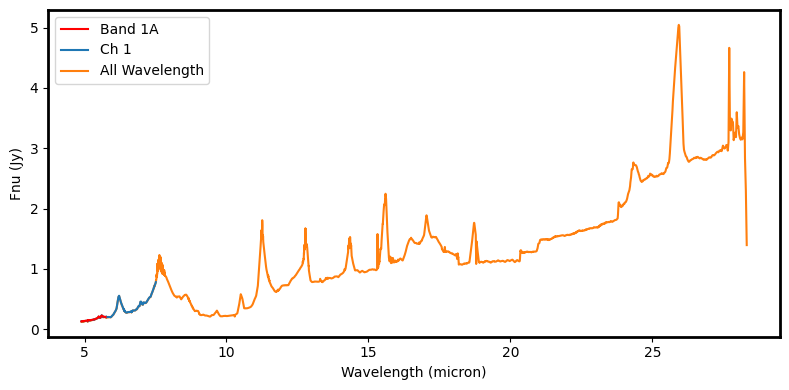

In [38]:
# Plot a spectrum of the source from the Ch1A, Ch1 and ALL cubes
spec1A = fits.open(spec3_dir + 'Level3_ch1-short_x1d.fits')
specfile_ch1 = glob.glob(spec3_dir + 'chancube_ch1*x1d.fits')
spec1 = fits.open(specfile_ch1[0])
specfile_all = glob.glob(spec3_dir + 'allcube_ch1*x1d.fits')
specALL = fits.open(specfile_all[0])

rc('axes', linewidth=2)            
fig, ax = plt.subplots(1,1, figsize=(8,4),dpi=100)

plt.plot(wave1A,spec1A['EXTRACT1D'].data['FLUX'],label='Band 1A',zorder=2,color='red')
plt.plot(wave1,spec1['EXTRACT1D'].data['FLUX'],label='Ch 1',zorder=1)
plt.plot(waveALL,specALL['EXTRACT1D'].data['FLUX'],label='All Wavelength',zorder=0)
plt.legend()
plt.xlabel('Wavelength (micron)')
plt.ylabel('Fnu (Jy)')
plt.tight_layout()

spec1A.close()
spec1.close()
specALL.close()

<b>Figure 2:</b> Spectra of point sources extracted from data cubes containing Ch1A (4.9 - 5.8 micron), Ch1 (4.9 - 7.5 micron), and all wavelengths (4.9 - 28.3 micron).

Finally, we can compare the JWST pipeline output spectrum to the input spectrum used to create the mirisim simulations.

In [39]:
# Find the mirisim input spectrum
inputsim = ascii.read(cache_dir + mirisim_dir + 'ngc5728_mirisim.txt')
inputsim['fnu'] /= 1e6 # Mirisim inputs are in units of uJy; convert to Jy to match pipeline outputs

# Find the 12-band pipeline output 1d spectra
sstring = spec3_dir + 'Level3*x1d.fits'
x1dfiles = np.array(sorted(glob.glob(sstring)))

In [40]:
# Loop over input spectra reading them into a big array
x1d_wave=[]
x1d_flux=[]
medwaves = []
for ii in range(0,len(x1dfiles)):
    hdu = fits.open(x1dfiles[ii])
    specdata = hdu['EXTRACT1D'].data
    x1d_wave.append(specdata['WAVELENGTH'])
    x1d_flux.append(specdata['FLUX'])
    medwaves.append(np.median(specdata['WAVELENGTH']))
    hdu.close()

x1d_wave = np.array(x1d_wave)
x1d_flux = np.array(x1d_flux)   
# For convenience, sort according to increasing wavelength
indx = np.argsort(medwaves)
x1d_wave = x1d_wave[indx]
x1d_flux = x1d_flux[indx]

# Introduce a 10% kludge factor to account for the fact that the mirisim PSF is oversized and thus loses too much flux beyond the aperture radius
x1d_flux *= 1.1

2021-06-18 13:03:59,290 - stpipe - WARNING - <ipython-input-40-0f96b02e98a2>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x1d_wave = np.array(x1d_wave)

2021-06-18 13:03:59,291 - stpipe - WARNING - <ipython-input-40-0f96b02e98a2>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x1d_flux = np.array(x1d_flux)



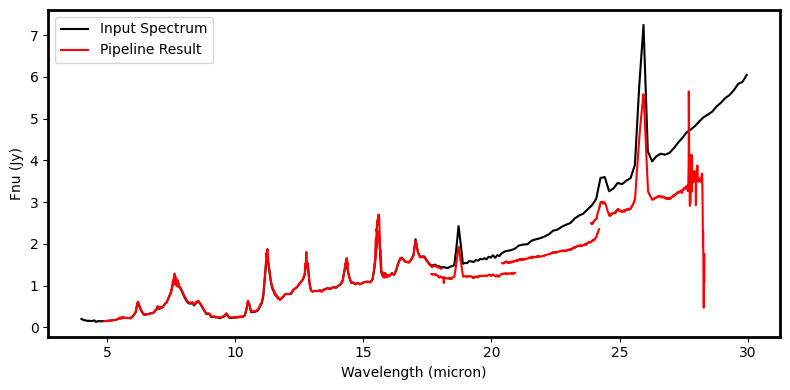

In [41]:
# Make the comparison plot
rc('axes', linewidth=2)            
fig, ax = plt.subplots(figsize=(8,4),dpi=100)

plt.plot(inputsim['wave'],inputsim['fnu'],label='Input Spectrum',color='black')
plt.xlabel('Wavelength (micron)')
plt.ylabel('Fnu (Jy)')
plt.tight_layout()

for ii in range(0,len(x1d_flux)):
    if (ii == 0):
        plt.plot(x1d_wave[ii],x1d_flux[ii],color='red',label='Pipeline Result')
    else:
        plt.plot(x1d_wave[ii],x1d_flux[ii],color='red')
        
plt.legend()


<b>Figure 3:</b> Comparison between simulated input spectrum and output spectrum produced by the pipeline.  A 10% kludge has been applied to correct for known deficiencies of the simulated PSF compared to the pipeline reference files; deviations at long wavelengths are due to calibration problems in the simulator.

In [42]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 9.3713 seconds


<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://www.stsci.edu/~dlaw/stsci_logo.png" alt="stsci_logo" width="200px"/> 